In [45]:
import torch
import time
from snn_delays.experimental_models.snn_mask import Masked_SNN
from snn_delays.snn import SNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.train_utils import train, get_device
from snn_delays.utils.test_behavior import tb_save_max_last_acc

'''
SHD dataset as in ablation study
'''

device = get_device()

# for reproducibility
torch.manual_seed(10)

dataset = 'shd'
total_time = 50
batch_size = 1024

# DATASET
DL = DatasetLoader(dataset=dataset,
                  caching='memory',
                  num_workers=0,
                  batch_size=batch_size,
                  total_time=total_time,
                  crop_to=1e6)
train_loader, test_loader, dataset_dict = DL.get_dataloaders()
          
num_epochs = 20

lr = 1e-3
# SNN CON DELAYS
taimu1 = time.time()

tau_m = 'normal'
delay = None
ckpt_dir = 'exp20_self_inh' 

mask = 1.0*torch.eye(64)

# snn = Masked_SNN(dataset_dict=dataset_dict, structure=(64, 2), connection_type='r',
#     delay=delay, delay_type='h', tau_m = tau_m,
#     win=total_time, loss_fn='mem_sum', batch_size=batch_size, device=device,
#     debug=True, mask=mask, mask_type='r')

snn = SNN(dataset_dict=dataset_dict, structure=(64, 2), connection_type='r',
    delay=delay, delay_type='h', tau_m = tau_m, debug=True,
    win=total_time, loss_fn='mem_sum', batch_size=batch_size, device=device)

snn.set_network()

Running on: cuda:0
[CropTime(min=0, max=1000000.0), ToFrame(sensor_size=(700, 1, 1), time_window=None, event_count=None, n_time_bins=50, n_event_bins=None, overlap=0, include_incomplete=False)]

[INFO] Delays: tensor([0])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0])

[INFO] Delays o: tensor([0])
1000.0
Delta t: 20.0 ms
mean of normal: -0.541324854612918


tensor([[-0.0520,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0000],
        [ 0.0000, -0.0336,  0.0000,  ...,  0.0000, -0.0000, -0.0000],
        [ 0.0000,  0.0000,  0.0578,  ...,  0.0000, -0.0000, -0.0000],
        ...,
        [-0.0000,  0.0000,  0.0000,  ..., -0.0665, -0.0000,  0.0000],
        [-0.0000,  0.0000, -0.0000,  ..., -0.0000, -0.0376,  0.0000],
        [-0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000, -0.0752]],
       device='cuda:0')


<Axes: xlabel='input', ylabel='output'>

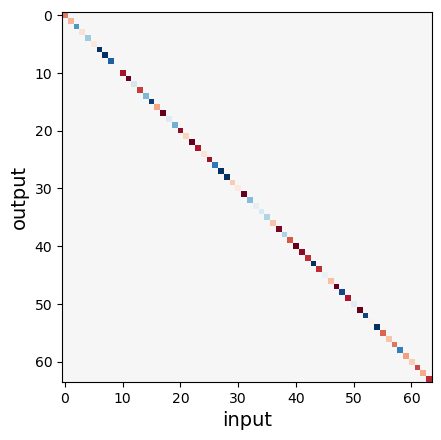

In [16]:
from snn_delays.utils.visualization_utils import plot_param

print(snn.f1_f1.linear.weight.data)

plot_param(snn.f1_f1.linear, mode='2D', vminmax=0.1)

In [46]:
a, b  = snn.test(test_loader, only_one_batch=True)

Test Loss: 6.1208086013793945
Avg spk_count per neuron for all 50 time-steps 4.427375793457031
Avg spk per neuron per layer [8.868057250976562, 8.841445922851562]
Test Accuracy of the model on the test samples: 5.664



In [47]:
snn.spike_state['f1'].shape

torch.Size([50, 1024, 64])

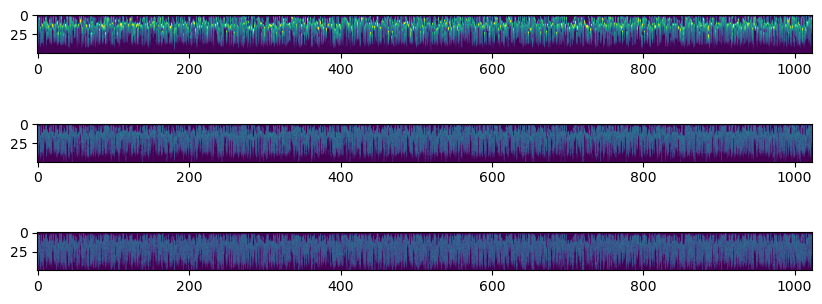

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))

vmin = 0.0
vmax = 1.0

plt.subplot(311)
plt.imshow(torch.mean(snn.spike_state['input'], dim=2).cpu().numpy(), vmin=vmin, vmax=vmax)
#plt.colorbar()
plt.subplot(312)
plt.imshow(torch.mean(snn.spike_state['f1'], dim=2).cpu().numpy(), vmin=vmin, vmax=vmax)
#plt.colorbar()
plt.subplot(313)
plt.imshow(torch.mean(snn.spike_state['f2'], dim=2).cpu().numpy(), vmin=vmin, vmax=vmax)
#plt.colorbar()

In [49]:
snn.to(device)
train(snn, train_loader, test_loader, lr, 50, dropout=0.0, 
    test_behavior=tb_save_max_last_acc, ckpt_dir=ckpt_dir, scheduler=(100, 0.95), test_every=1)

training shd50_l2_1d1.t7 for 50 epochs...
Epoch [1/50], learning_rates 0.001000, 0.100000


c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to re

Step [2/7], Loss: 5.04281
l1_score: 0
Step [4/7], Loss: 5.37984
l1_score: 0
Step [6/7], Loss: 5.33633
l1_score: 0
Step [8/7], Loss: 3.45335
l1_score: 0
Time elasped: 50.105692863464355
Test Loss: 3.3235417207082114
Avg spk_count per neuron for all 50 time-steps 5.129248142242432
Avg spk per neuron per layer [10.543686506183745, 9.973304991166078]
Test Accuracy of the model on the test samples: 6.228

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\exp20_self_inh
Gradient norm for 'tau_m_1': 0.0005
Gradient norm for 'tau_m_2': 0.0054
Gradient norm for 'tau_m_o': 0.3569
Gradient norm for 'f0_f1.weight': 0.3066
Gradient norm for 'f1_f1.weight': 0.0757
Gradient norm for 'f1_f2.weight': 0.8968
Gradient norm for 'f2_f2.weight': 0.9387
Gradient norm for 'f2_o.weight': 9.0795
saving max acc: 6.22791519434629
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\exp20_self_inh
Epoch [2/50], learning_rates 0.001000, 0.

tensor([[-0.0062,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0000],
        [ 0.0000,  0.0122,  0.0000,  ...,  0.0000, -0.0000, -0.0000],
        [ 0.0000,  0.0000,  0.0747,  ...,  0.0000, -0.0000, -0.0000],
        ...,
        [-0.0000,  0.0000,  0.0000,  ..., -0.0428, -0.0000,  0.0000],
        [-0.0000,  0.0000, -0.0000,  ..., -0.0000,  0.0102,  0.0000],
        [-0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000, -0.0775]],
       device='cuda:0')


<Axes: xlabel='input', ylabel='output'>

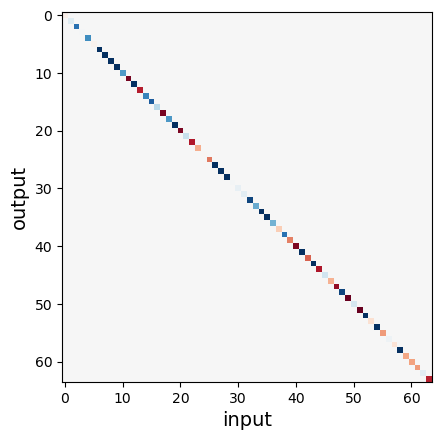

In [39]:
print(snn.f1_f1.linear.weight.data)
plot_param(snn.f1_f1.linear, mode='2D', vminmax=0.1)

Test Loss: 1.065524697303772
Avg spk_count per neuron for all 50 time-steps 7.687053680419922
Avg spk per neuron per layer [16.07818603515625, 14.670028686523438]
Test Accuracy of the model on the test samples: 72.656



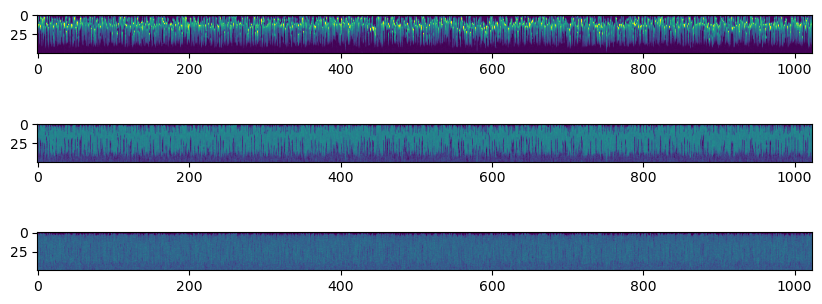

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))

a, b  = snn.test(test_loader, only_one_batch=True)

vmin = 0.0
vmax = 1.0

plt.subplot(311)
plt.imshow(torch.mean(snn.spike_state['input'], dim=2).cpu().numpy(), vmin=vmin, vmax=vmax)
#plt.colorbar()
plt.subplot(312)
plt.imshow(torch.mean(snn.spike_state['f1'], dim=2).cpu().numpy(), vmin=vmin, vmax=vmax)
#plt.colorbar()
plt.subplot(313)
plt.imshow(torch.mean(snn.spike_state['f2'], dim=2).cpu().numpy(), vmin=vmin, vmax=vmax)
#plt.colorbar()